In [ ]:
# default_exp engine.point_process

In [ ]:
%load_ext autoreload
%autoreload 2

# Emitter distribution

> Definition of the class used to simulate random emitter positions and intensities

In [ ]:
#export
from decode_fish.imports import *
from torch import distributions as D, Tensor
from torch.distributions import Distribution
from decode_fish.funcs.utils import *

In [ ]:
#export
class PointProcessUniform(Distribution):
    """
    This class is part of the generative model and uses the probability local_rate to generate sample locations on the voxel grid.  
    For each emitter we then sample x-,y- and z-offsets uniformly in the range [-0.5,0.5] to get continuous locations.
    Intensities are sampled from a gamma distribution torch.distirubtions.gamma(int_conc, int_rate) which is shifted by int_loc.
    Together with the microscope.scale and the PSF this results in the overall brightness of an emitter.
    
    Args:
        local_rate torch.tensor . shape(BS, C, H, W, D): Local rate
        int_conc=0., int_rate=1., int_loc (float): parameters of the intensity gamma distribution
        sim_iters (int): instead of sampling once from local_rate, we sample sim_iters times from local_rate/sim_iters. 
            This results in the same average number of sampled emitters but allows us to sample multiple emitters within one voxel.

    """
    def __init__(self, local_rate: torch.tensor, int_conc=0., int_rate=1., int_loc=1., sim_iters: int = 5, channels=1, n_bits=1, sim_z=True, codebook=None, int_option=1):

        assert sim_iters >= 1
        self.local_rate = local_rate
        self.device = self._get_device(self.local_rate)
        self.sim_iters = sim_iters
        self.int_conc = int_conc
        self.int_rate = int_rate
        self.int_loc = int_loc
        self.channels = channels
        self.n_bits = n_bits
        self.sim_z=sim_z
        self.codebook=codebook
        self.int_option = int_option
        
    def sample(self, from_code_book=False, phasing=False):

        res_ = [self._sample(self.local_rate/self.sim_iters, from_code_book, phasing) for i in range(self.sim_iters)]
        locations = torch.cat([i[0] for i in res_], dim=0)
        x_offset = torch.cat([i[1] for i in res_], dim=0)
        y_offset = torch.cat([i[2] for i in res_], dim=0)
        z_offset = torch.cat([i[3] for i in res_], dim=0)
        intensities = torch.cat([i[4] for i in res_], dim=0)
        codes = torch.cat([i[6] for i in res_], dim=0) if from_code_book else None

        return list(locations.T), x_offset, y_offset, z_offset, intensities, res_[0][5], codes

    def _sample(self, local_rate, from_code_book, phasing):

        output_shape = list(local_rate.shape)
        local_rate = torch.clamp(local_rate,0.,1.)
        locations = D.Bernoulli(local_rate).sample()
        n_emitter = int(locations.sum().item())
        x_offset = D.Uniform(low=-0.5, high=0.5).sample(sample_shape=[n_emitter]).to(self.device)
        y_offset = D.Uniform(low=-0.5, high=0.5).sample(sample_shape=[n_emitter]).to(self.device)
        z_offset = D.Uniform(low=-0.5, high=0.5).sample(sample_shape=[n_emitter]).to(self.device)
        
#         intensities = torch.zeros([n_emitter, self.channels]).to(self.device)
        if self.int_option == 1:
            intensities = D.Gamma(self.int_conc, self.int_rate).sample(sample_shape=[n_emitter, self.channels]).to(self.device) + self.int_loc 
        elif self.int_option == 2:
            intensities = D.Gamma(self.int_conc, self.int_rate).sample(sample_shape=[n_emitter, 1]).to(self.device) + self.int_loc 
            intensities = intensities.repeat_interleave(self.channels, 1)
        elif self.int_option == 3:
            intensities = D.Gamma(self.int_conc, self.int_rate).sample(sample_shape=[n_emitter, 1]).to(self.device) + self.int_loc 
            intensities = intensities.repeat_interleave(self.channels, 1)
            int_noise = D.Uniform(low=.7, high=1.5).sample(sample_shape=intensities.shape).to(self.device)
            intensities *= int_noise
            
        # If 2D data z-offset is 0
        if not self.sim_z:
            z_offset *= 0
        else:
            # If 2D data and we simulate z we use whole tanh range
            if output_shape[-3] == 1:
                 z_offset *= 2.  
    
        locations = locations.nonzero(as_tuple=False)

        if self.channels > 1:
            code_draw = None
            if from_code_book:
                code_draw = torch.randint(0, len(self.codebook), size=[n_emitter])
                ch_draw = self.codebook[code_draw]
#                 code_draw = torch.randint(0, len(self.codebook) + self.n_dump_codes,size=[n_emitter])
    
#                 ch_draw = torch.zeros([n_emitter, self.channels], dtype=torch.bool).to(self.device)
#                 code_inds = code_draw<len(self.codebook)
#                 dump_inds = code_draw>=len(self.codebook)
#                 # All draws lower than the codebook length get a code from it
#                 ch_draw[code_inds] = self.codebook[code_draw[code_inds]].to(self.device)
#                 # All draws higher than the codebook length get a random code with an average length of n_bits, but at least 1
#                 # There is a certain probability that dump codes are in the codebook. We ignore it for now. 
#                 ch_draw[dump_inds, torch.randint(0, self.channels, size=[sum(dump_inds)])] = 1
#                 ch_draw[dump_inds] += torch.distributions.Binomial(total_count=1, probs=torch.ones([sum(dump_inds),self.channels])/self.channels*(self.n_bits - 1)).sample().type(torch.bool).to(self.device)
                
#                 # n_dump_codes controsl the rate of out-of-code book codes, but they all get assigned to the code_index len(codebook)+1
#                 code_draw = torch.clamp_max(code_draw, len(self.codebook))

            else:

                m_draw = torch.multinomial(torch.ones([n_emitter,self.channels])/self.channels, self.n_bits, replacement=False)
                ch_draw = torch.zeros(intensities.shape).to(intensities.device)
                ch_draw.scatter_(index=m_draw.to(intensities.device), dim=1, value=1)
                
            intensities = intensities.to(self.device) * ch_draw.to(self.device)
            output_shape.insert(1, self.channels)
            
        return locations, x_offset, y_offset, z_offset, intensities, tuple(output_shape), code_draw

    @staticmethod
    def _get_device(x):
        return getattr(x, 'device')
    

def list_to_locations(locations, output_shape):
    tmp =torch.zeros(output_shape, device=locations[0].device)
    coord = torch.stack(locations).T
    #incase you have multiple emitter present
    for i in coord: tmp[tuple(i)] += 1
    return tmp

In [ ]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [ ]:
point_process = PointProcessUniform(local_rate = torch.ones([5,1,48,48]).cuda()*.3, int_conc=3, int_rate=1, int_loc=1, sim_iters=1, channels=16, n_bits=1, codebook=torch.tensor(code_ref, dtype=torch.bool), int_option=3)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(from_code_book=False, phasing=False)

torch.Size([3549, 16]) torch.Size([3549, 16])


In [ ]:
ints_3d[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.7299, 0.0000, 1.3594, 1.9429, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')

(array([280., 272., 314., 296., 320., 268., 306., 299., 276., 836.]),
 array([  0.,  14.,  28.,  42.,  56.,  70.,  84.,  98., 112., 126., 140.]),
 <BarContainer object of 10 artists>)

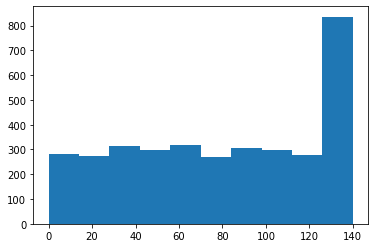

In [ ]:
plt.hist(cpu(codes))

In [ ]:
for l in locs_3d:
    print(l.shape)
print('x')
print(x_os_3d.shape)
print('ints')
print(ints_3d.shape)
print('codes')
print(codes.shape)

torch.Size([3467])
torch.Size([3467])
torch.Size([3467])
torch.Size([3467])
x
torch.Size([3467])
ints
torch.Size([3467, 16])
codes
torch.Size([3467])


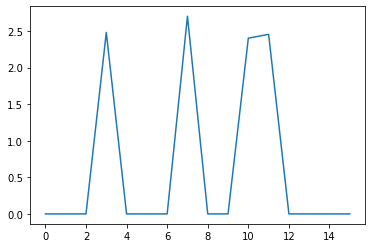

In [ ]:
plt.plot(ints_3d[6].detach().cpu())

In [ ]:
torch.save([locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes], '../data/sim_var_code_class2.pt')

In [ ]:
# for i in range(1000):
#     locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample(from_code_book=False, phasing=False)

In [ ]:
def sample_to_df(locs, x_os, y_os, z_os, ints, codes, px_size_zyx=[100,100,100]):
    
    x = locs[-1] + x_os + 0.5 
    y = locs[-2] + y_os + 0.5 
    z = locs[-3] + z_os + 0.5 
    
    n_gt = len(x)
    channels = ints.shape[1]
    
    frame_idx = locs[0]
    
    df = DF({'loc_idx': torch.arange(n_gt),
             'frame_idx': frame_idx.cpu(),
             'x': x.cpu()*px_size_zyx[2],
             'y': y.cpu()*px_size_zyx[1], 
             'z': z.cpu()*px_size_zyx[0]}) 
    
    for i in range(channels):
        df[f'int_{i}'] = ints[:,i].cpu()
        
    df['code_inds'] = codes
    df['ints'] = ints.sum(-1).cpu()

    return df

In [ ]:
# from decode_fish.funcs.output_trafo import sample_to_df
# locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample(from_code_book=False, phasing=False)
target_df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, codes, px_size_zyx=[100,100,100])

In [ ]:
target_df

,loc_idx,frame_idx,x,y,z,int_0,int_1,int_2,int_3,int_4,...,int_8,int_9,int_10,int_11,int_12,int_13,int_14,int_15,code_inds,ints
0,0,0,2.897924,78.170433,9.070373,5.566784,0.000000,0.000000,5.825050,0.000000,...,0.000000,0.0,0.000000,5.68182,0.000000,0.000000,0.000000,0.000000,131,21.205256
1,1,0,240.189865,60.688274,92.872772,0.000000,4.464477,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,4.742773,0.000000,0.000000,74,23.133686
2,2,0,725.984436,16.204966,121.603584,0.000000,0.000000,0.000000,0.000000,2.864076,...,5.062429,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,3.939285,109,17.454760
3,3,0,1136.664062,35.388268,37.142086,0.000000,0.000000,3.703309,5.919896,0.000000,...,5.156334,0.0,0.000000,0.00000,0.000000,0.000000,4.491377,0.000000,96,19.270916
4,4,0,1605.829956,31.875360,24.219370,0.000000,0.965376,0.000000,0.000000,0.000000,...,0.000000,0.0,1.290627,0.00000,0.000000,0.000000,0.000000,1.246665,50,5.291564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4869,4869,6,2481.452881,4741.678223,5.525219,0.000000,2.764194,0.000000,0.000000,0.000000,...,3.105262,0.0,0.000000,0.00000,0.000000,0.000000,2.831017,0.000000,44,10.725827
4870,4870,6,2649.369141,4753.849609,3.449392,0.000000,0.000000,0.000000,0.000000,1.760245,...,0.000000,0.0,2.262176,0.00000,2.658659,0.000000,0.000000,2.465444,124,9.146524
4871,4871,6,3159.412598,4733.369141,99.721954,0.000000,0.000000,0.000000,0.000000,2.404217,...,0.000000,0.0,3.443761,0.00000,2.965225,0.000000,0.000000,3.896845,124,12.710048
4872,4872,6,4489.710449,4762.860352,-49.021446,0.000000,0.000000,2.683888,0.000000,2.439274,...,0.000000,0.0,0.000000,0.00000,0.000000,2.305282,0.000000,0.000000,84,10.258597


In [ ]:
len(target_df)

1376

In [ ]:
target_df.loc[0]

loc_idx        0.000000
frame_idx      0.000000
x            631.309143
y             85.199944
z             32.783012
int_0          1.799818
int_1          0.000000
int_2          0.000000
int_3          0.000000
int_4          0.000000
int_5          0.000000
int_6          0.000000
int_7          0.000000
int_8          0.000000
int_9          3.552146
int_10         0.000000
int_11         0.000000
int_12         0.000000
int_13         0.000000
int_14         5.447395
int_15         3.346759
code_inds     48.000000
ints          14.146118
Name: 0, dtype: float64

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.
